<a href="https://colab.research.google.com/github/Ritik-912/AI-legal-word-document-assistant/blob/main/AI_legal_word_document_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mounting Google Drive for PDF access

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# AI LEGAL WORD DOCUMENT ASSISTANT USING GOOGLE GEN AI

## Extracting and Preprocessing of text

In [ ]:
# Extract and read PDF contents
%pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
# read PDF
import fitz
# Use for environment and path related works
import os

# List of paths of pdf files to read
pdf_folder_path = "/content/drive/MyDrive/LegalAssistant"
pdf_files = [os.path.join(pdf_folder_path, file) for file in os.listdir(pdf_folder_path) if file.endswith('.pdf')]
print(f"Found {len(pdf_files)} PDF files.")

# function to extract text from pdf
def extract_text_as_dict(pdf_file):
    doc = fitz.open(pdf_file)
    data = {}
    current_title = None
    current_text = ""

    for page in doc:
        blocks = page.get_text("blocks")
        for block in blocks:
            lines = block[4].splitlines()
            if len(lines) == 1:  # Potential title
                if current_title:  # Store previous title and text
                    data[current_title] = current_text
                current_title = lines[0].strip()
                current_text = ""
            else:  # Add lines to current text
                current_text += " ".join(lines)

    # Store the last title and text
    if current_title:
        data[current_title] = current_text

    return data

Found 1 PDF files.


In [ ]:
# Store all text extracted from all PDF
Text = dict()

# Extracting text from each PDF
for pdf_file in pdf_files:
    Text.update(extract_text_as_dict(pdf_file))

import pandas as pd
# Organize contents of dictionary into dataframe for better visualization
series = pd.Series(Text)
df = pd.DataFrame(series).reset_index()
df.columns = ['Title', 'Text']

print('Maximum Length Of a Paragraph = ',df['Text'].apply(len).max())
print(df)

Maximum Length Of a Paragraph =  2417
                                                  Title  \
0                             THE CONSTITUTION OF INDIA   
1                                              PREAMBLE   
2     WE, THE PEOPLE OF INDIA, having solemnly resol...   
3          REPUBLIC] and to secure to all its citizens:   
4              JUSTICE, social, economic and political;   
...                                                 ...   
4413                                       APPENDIX III   
4414  1DECLRATION UNDER ARTICLE 370(3) OF THE CONSTI...   
4415                                           C.O. 273   
4416  In exercise of the powers conferred by clause ...   
4417  “370. All provisions of this Constitution, as ...   

                                                   Text  
0                                                        
1                                                        
2     India into a  1[SOVEREIGN SOCIALIST SECULAR DE...  
3                    

In [ ]:
# Iterate over rows to merge titles with consecutive empty text
merged_rows = []
current_title = ""

for index, row in df.iterrows():
    if not row['Text']:
        # Concatenate titles for consecutive empty text rows
        current_title += ' ' + row['Title'].strip()
    elif current_title:
        # If there were consecutive empty text rows, add titles to the next non-empty text row
        merged_rows.append({'Title': current_title.strip(), 'Text': row['Text']})
        current_title = ""
    else:
        # If there were no consecutive empty text rows, keep the row as it is
        merged_rows.append({'Title': row['Title'].strip(), 'Text': row['Text']})

# Create a new DataFrame with merged rows
df = pd.DataFrame(merged_rows)

# Display the result
print(df)

                                                  Title  \
0                    THE CONSTITUTION OF INDIA PREAMBLE   
1     REPUBLIC] and to secure to all its citizens: J...   
2               DEMOCRATIC REPUBLIC" (w.e.f. 3-1-1977).   
3     PART I THE UNION AND ITS TERRITORY 1. Name and...   
4     and] (c) such other territories as may be acqu...   
...                                                 ...   
1899  (c) references to the Government of the said S...   
1900  (d) in proviso to clause (3) of article 370 of...   
1901  1.Published with the Ministry of Law and Justi...   
1902  371 APPENDIX III 1DECLRATION UNDER ARTICLE 370...   
1903  “370. All provisions of this Constitution, as ...   

                                                   Text  
0     India into a  1[SOVEREIGN SOCIALIST SECULAR DE...  
1     November, 1949, do HEREBY ADOPT, ENACT AND GIV...  
2                                                     2  
3     (a) the territories of the States;  2[(b) the ...  
4

## Loading LLM Model for Embedding creation and Query Searching

In [2]:
# Large Language Model Gemini
%pip install -U -q google.generativeai

In [3]:
# work with filesystem paths
import pathlib

# formatting and wrapping of text blocks
import textwrap

# Gemini LLM
import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store API key
from google.colab import userdata

# display images, HTML, Markdown, multimedia
from IPython.display import display

# render Markdown-formatted text
from IPython.display import Markdown

# convert text with bullet points to formatted
# Markdown with proper list indentation
def to_markdown(text):
    text = text.replace('•', '  *')
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

# GOOGLE_API_KEY fetching from environment variable
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Available Gemini models
for m in genai.list_models():
    print(m.name)
    if 'generateContent' in m.supported_generation_methods:
        print('content generation:\n',m.name)
    if 'embedContent' in m.supported_generation_methods:
        print('Embedding Creation:\n',m.name)
# RETRIEVAL_QUERY: Specifies the given text is a query in a search/retrieval setting
# RETRIEVAL_DOCUMENT: Specifies the given text is a document in a search/retrieval setting

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-pro
content generation:
 models/gemini-pro
models/gemini-pro-vision
content generation:
 models/gemini-pro-vision
models/embedding-001
Embedding Creation:
 models/embedding-001
models/aqa


## Embeddings Visualization

In [ ]:
# Get embeddings of each text & add an embeddings column in df
def embed_fn(title, text):
    return genai.embed_content(model='models/embedding-001',
                               content=text,
                               task_type="retrieval_document",
                               title=title)["embedding"]
import numpy as np
parts = np.array_split(df, 4)
parts[0]['Embeddings'] = parts[0].apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
parts[1]['Embeddings'] = parts[1].apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
parts[2]['Embeddings'] = parts[2].apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
parts[3]['Embeddings'] = parts[3].apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
df = pd.concat(parts)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61482 (\uf02a) missing from curren

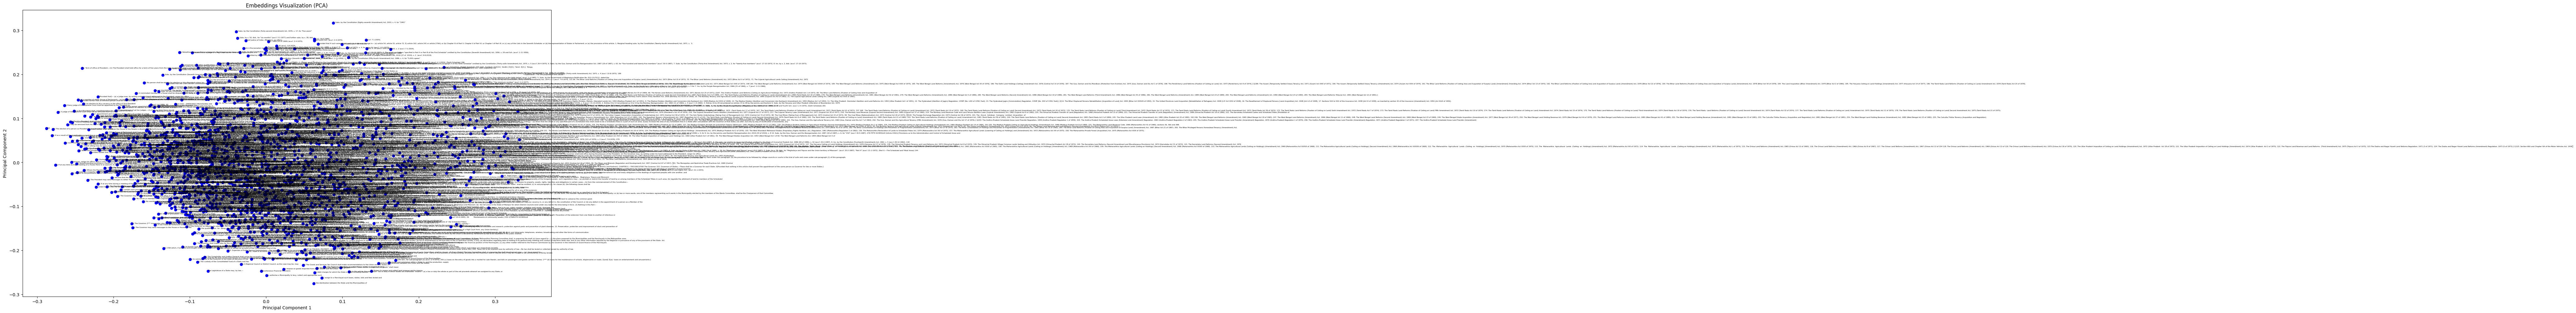

In [ ]:
# Plotting the embeddings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# # Insert embedding list into DataFrame
# df['Embedding'] = embeddings

# Save for future Use
df.to_csv('/content/drive/MyDrive/LegalAssistant/data.csv', index=False)

# Extract embeddings as NumPy array
embeddings = np.array(df['Embeddings'].to_list())

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(22, 12))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], color='blue', marker='o')

# Annotate points with text
for i, txt in enumerate(df['Title']):
    plt.annotate(txt, (embeddings_pca[i, 0], embeddings_pca[i, 1]), fontsize=4)

# Set plot labels & Show plot
plt.title('Embeddings Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## VectorStore Creation

In [4]:
# Non-Metric Space Library open-source library for
# similarity search in non-metric spaces
%pip install nmslib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578485 sha256=11d2cf8c07aaa3977e39737acd745d483efa432602435b4fe470ad40ed2683cb
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib


In [ ]:
import nmslib

# Create HNSW (Hierarchical Navigable Small World Graph) index
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Save for future use
index.saveIndex('/content/drive/MyDrive/LegalAssistant/hnsw_index.nmslib')

In [8]:
import nmslib
import pandas

# load DataFrame
df = pandas.read_csv('/content/drive/MyDrive/LegalAssistant/data.csv')

# load vectorstore index
index = nmslib.init(method='hnsw', space='cosinesimil')
index.loadIndex('/content/drive/MyDrive/LegalAssistant/hnsw_index.nmslib')

## Prepairing Model for Q & A

In [9]:
# Function to retrieve nearest neighbors
def relatedTexts(query, dataframe, vectordb):
    """
    Compute the distances between the query and each document in the dataframe
    using the approximate k nearest neighbor.
    """
    query_embedding = genai.embed_content(model='models/embedding-001',
                                          content=query,
                                          task_type="retrieval_query")['embedding']
    neighbors, distances = vectordb.knnQuery(query_embedding, k=5)
    return dataframe.iloc[neighbors]['Text'] # Return text from index with max value

# Generation of prompt from User Query For better Search Results
def make_prompt(query, relevant_passage):
    escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
    prompt = textwrap.dedent("""You are a helpful and informative Legal Advisor bot for indian citizens that answers questions using text \
    from the reference passage included below. Be sure to respond in a complete sentence, being comprehensive, including \
    However, you are talking to a non-technical audience, so be sure to break down complicated concepts and \
    all relevant background information. strike a friendly and converstional tone. \ Also anything you know about indian laws and \
    Code of criminal procedure and code of civil procedure in inida include their references in your answers.\
    If the passage is irrelevant to the answer, you may ignore it.
    QUESTION: '{query}'
    PASSAGE: '{relevant_passage}'

    ANSWER:
    """).format(query=query, relevant_passage=escaped)
    return prompt

### Testing model

In [12]:
query = "what can you answer"
Info = relatedTexts(query, df, index)
prompt = make_prompt(query, Info)
model = genai.GenerativeModel('models/gemini-pro')
answer = model.generate_content(prompt)
Markdown(answer.text)

My capabilities are limited to answering questions related to Indian laws, the Code of Criminal Procedure, and the Code of Civil Procedure. If you have any questions regarding these topics, I'd be happy to assist you.

# 9. Web App Deployment

In [13]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 989.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=cb01f46a5a6908fb3a070c77a734a67302f301411753d4d0ce5062df237ec6bd
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [14]:
import anvil.server
anvil.server.connect('RUNWS225LNCC2SXIJ7JZOVL6-UWO7UCPAA2YCJ2DC')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [15]:
@anvil.server.callable
def answer_generation(query):
    Info = relatedTexts(query, df, index)
    prompt = make_prompt(query, Info)
    model = genai.GenerativeModel('models/gemini-pro')
    answer = model.generate_content(prompt)
    return answer.text

In [ ]:
anvil.server.wait_forever()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprec

# AI Legal Word Document Assistant Using llama2 13 billion parameters

LANGCHAIN SETUP for API acess of LLM

In [17]:
!pip install replicate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


In [18]:
!pip install langchain
import os
os.environ["REPLICATE_API_TOKEN"] = "r8_UX2bUR3y1qvKXJOYl4xr06eYRHhVF5h2ayAsc"
from langchain.llms import Replicate

# Use the Llama 2 model hosted on Replicate
llama2_13b = "meta/llama-2-13b-chat:f4e2de70d66816a838a89eeeb621910adffb0dd0baba3976c96980970978018d"

# Temperature: Adjusts randomness of outputs, greater than 1 is random and 0 is
# deterministic, 0.75 is a good starting value
# top_p: When decoding text, samples from the top p percentage of most likely tokens
# and lower to ignore less likely tokens
# max_new_tokens: Maximum number of tokens to generate. A word is generally 2-3 tokens

llama_model = Replicate(
    model=llama2_13b,
    model_kwargs={"temperature": 0.75,"top_p": 1, "max_new_tokens":1000}
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.5 MB/s eta 0:00:00


## Extracting and tokenizing Texts

In [19]:
!pip install pdf2image
!pip install pdfminer
!pip install pdfminer.six
!pip install unstructured
!pip install pypdf
!pip install tiktoken
!pip install textract
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.6 MB/s eta 0:00:00
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140080 sha256=4b05efda39d704f427cb9fcc627bafa20e17b4560ec02b376a7d6f021f92aa31
  Stored in directory: /root/.cache/pip/wheels/4e/c1/68/f7bd0a8f514661f76b5cbe3b5f76e0033d79f1296012cbbf72
Successfully built pdfminer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.

In [27]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 44.7 MB/s eta 0:00:00


In [28]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
# Function takes in the pdf data and returns the splits for further processing
def get_pdf_splits(pdf_file):
    loader = PyPDFLoader(pdf_file)
    pages = loader.load_and_split()

    textSplit = RecursiveCharacterTextSplitter(chunk_size=128,
                                             chunk_overlap=12,
                                             length_function=len)

    doc_list = []

    #Pages will be list of pages
    for pg in pages:
        pg_splits = textSplit.split_text(pg.page_content)
        doc_list.extend(pg_splits)

    return doc_list

def embed_index(doc_list, embed_fn, index_store):
  """Function takes in existing vector_store,
  new doc_list and embedding function that is
  initialized on appropriate model. Local or online.
  New embedding is merged with the existing index. If no
  index given a new one is created"""
  #check whether the doc_list is documents, or text
  try:
    faiss_db = FAISS.from_documents(doc_list, embed_fn)
  except Exception as e:
    faiss_db = FAISS.from_texts(doc_list, embed_fn)

  if os.path.exists(index_store):
    local_db = FAISS.load_local(index_store,embed_fn)
    #merging the new embedding with the existing index store
    local_db.merge_from(faiss_db)
    print("Merge completed")
    local_db.save_local(index_store)
    print("Updated index saved")
  else:
    faiss_db.save_local(folder_path=index_store)
    print("New store created...")

## LOAD THE DOCUMENT

In [29]:
pdf_folder_path = "/content/drive/MyDrive/LegalAssistant"
pdf_files = [os.path.join(pdf_folder_path, file) for file in os.listdir(pdf_folder_path) if file.endswith('.pdf')]
print(f"Found {len(pdf_files)} PDF files.")
all_docs=[]
for pdf_file in pdf_files:
    all_docs.extend(get_pdf_splits(pdf_file))

Found 1 PDF files.


## Create & Store embeddings into vector database


In [24]:
%pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 864.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a612da458cb91631ccfd01845ed406489eeddb693f98af0290cd92f2ddfe1d5b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [25]:
from langchain.embeddings import HuggingFaceEmbeddings
model_name = "sentence-transformers/all-mpnet-base-v2" # embedding model
model_kwargs = {"device": "cpu"}
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [30]:
embed_index(doc_list=all_docs,
            embed_fn=embeddings,
            index_store='new_index')

New store created...


## Load saved vector database for searching

In [31]:
vectorstore = FAISS.load_local('new_index',embeddings)

## Query against given data

In [33]:
from langchain.chains import ConversationalRetrievalChain
chain = ConversationalRetrievalChain.from_llm(llama_model, vectorstore.as_retriever(), return_source_documents=True)

chat_history = []
query = "What is our Fundamental Duty as per Constitution of India?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Hello! As a helpful assistant, I'd be happy to help answer your question about the fundamental duties of Indian citizens as per the Constitution of India.

As per Article 51A of the Constitution, it is the fundamental duty of every citizen of India to:

1. Abide by the Constitution and respect its ideals and institutions, the National Flag and the National Anthem.

So, in short, our fundamental duty as Indian citizens is to respect and uphold the Constitution of India and its ideals, symbols, and institutions.


In [34]:
# This time your previous question and answer will be included
# as a chat history which will enable the ability to ask follow up questions.
chat_history = [(query, result["answer"])]
query = "Among them which is most Fundamental?"
result = chain({"question": query, "chat_history": chat_history})
print(result['answer'])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprec

 Based on the provided context, the most fundamental duty of an Indian citizen, as per the Constitution of India, is:

a) To respect and uphold the Constitution and its ideals, symbols, and institutions.


## User interaction with Model

In [35]:
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

def format_answer(answer):
    # Split the answer into bullet points based on patterns like (1), (2), 1., 2., 1), 2), ARTICLE 1., ARTICLE (1), ARTICLE 1), etc.
    points = re.split(r'\(\d+\)|\d+\.\s|\d+\)\s|ARTICLE\s+\(\d+\)|ARTICLE\s+\d+\.\s|ARTICLE\s+\d+\)\s', answer)
    bullet_points = "<br>".join([f"- {point.strip()}" for point in points if point.strip()])
    return bullet_points


def on_submit(_):
    query = input_box.value
    input_box.value = ""
    if query.lower() == 'exit':
        print("Thank you for using AI law assistant!")
        return

    result = chain({"question": query, "chat_history": chat_history})

    # Apply the formatting function to the result['answer']
    formatted_answer = format_answer(result['answer'])

    chat_history.append((query, formatted_answer))
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Legal Assistant:</font></b> {formatted_answer}'))

def clear_history(_):
    global chat_history
    chat_history = []
    clear_output()
    print("Welcome to AI Law Assistent! Type 'exit' to stop.")
    display(input_box)
    display(clear_button)

all_chat_histories = []
chat_history = []

def start_new_conversation(_):
    global chat_history
    all_chat_histories.append(chat_history[:])
    chat_history = []
    print("Starting a new conversation. Welcome to AI Law Assistant! Type 'exit' to stop.")
    display(input_box)
    display(clear_button)
    display(new_conversation_button)
    display(view_conversations_button)

print("Welcome to AI Law Assistent! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your query here:')
input_box.on_submit(on_submit)

clear_button = widgets.Button(description="Clear History")
clear_button.on_click(clear_history)

new_conversation_button = widgets.Button(description="Start New Conversation")
new_conversation_button.on_click(start_new_conversation)

display(input_box)
display(clear_button)
display(new_conversation_button)

Welcome to AI Law Assistent! Type 'exit' to stop.


Text(value='', placeholder='Please enter your query here:')

Button(description='Clear History', style=ButtonStyle())

Button(description='Start New Conversation', style=ButtonStyle())

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


HTML(value='<b>User:</b> what is article 370')

HTML(value='<b><font color="blue">Legal Assistant:</font></b> - Based on the context provided, Article 370 is …

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprec

HTML(value='<b>User:</b> w')

HTML(value='<b><font color="blue">Legal Assistant:</font></b> - Based on the provided context, I can help answ…

In [36]:
import re
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Define the CSS styles
css_style = '''
<style>
    .widget-box {
        border: 12px solid #007bff;
        padding: 22px;
        background-color: #2c2c2c;
        box-shadow: 0px 0px 10px #1a1a1a;
    }
    .chat-history {
        border: 1px solid #ccc;
        height: 300px;
        overflow-y: scroll;
        padding: 10px;
        border-radius: 10px;
        font-family: Arial, sans-serif;
        font-size: 14px;
        line-height: 1.5;
        color: #ffff00;
        background-color: #222;
    }
    .user-message {
        color: #007bff;
        font-weight: bold;
    }
    .bot-message {
        color: #28a745;
        font-weight: bold;
    }
    .header-title {
        text-align: center;
        color: #b8daff;
        font-weight: bold;
    }
</style>
'''

# Display the CSS styles
display(HTML(css_style))

# Same format_answer function
def format_answer(answer):
    points = re.split(r'\(\d+\)|\d+\.\s|\d+\)\s|ARTICLE\s+\(\d+\)|ARTICLE\s+\d+\.\s|ARTICLE\s+\d+\)\s', answer)
    bullet_points = "<br>".join([f"- {point.strip()}" for point in points if point.strip()])
    return bullet_points

# Function to handle user query
def on_submit(_):
    query = input_box.value
    input_box.value = ""
    if query.lower() == 'exit':
        print("Thank you for using AI law assistant!")
        return

    result = chain({"question": query, "chat_history": chat_history})
    formatted_answer = format_answer(result['answer'])
    chat_history.append((query, formatted_answer))

    chat_display.value += f'<div class="chat-history"><div class="user-message">User:</div> {query}<div class="bot-message">Chatbot:</div> {formatted_answer}<br><hr></div>'

# Function to clear chat history
def clear_history(_):
    global chat_history
    chat_history = []
    chat_display.value = ""

chat_history = []

# Widgets
input_box = widgets.Text(placeholder='Please enter your query here:', layout=widgets.Layout(width="80%"))
input_box.on_submit(on_submit)

submit_button = widgets.Button(description="Submit", button_style="info")
submit_button.on_click(on_submit)

clear_button = widgets.Button(description="Clear History", button_style="warning")
clear_button.on_click(clear_history)

chat_display = widgets.HTML(value="", layout=widgets.Layout(height="300px"))

# Container for widgets
container = widgets.VBox([
    widgets.HTML("<h2 class='header-title'>Welcome to AI Law Assistant! Type 'exit' to stop.</h2><h4 class='header-title'>AI legal Word Document Assistant</h4>"),
    widgets.HBox([input_box, submit_button]),
    widgets.HTML("<h4>Chat History:</h4>"),
    widgets.Box([chat_display], layout=widgets.Layout(padding="10px", border="1px solid #ccc")),
    clear_button
], layout=widgets.Layout(padding="10px"))

# Display the container
display(container)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/d

In [37]:
@anvil.server.callable
def answer_generation(query):
    if query.lower() == 'exit':
        print("Thank you for using AI law assistant!")
        return

    result = chain({"question": query, "chat_history": chat_history})

    # Apply the formatting function to the result['answer']
    formatted_answer = format_answer(result['answer'])

    chat_history.append((query, formatted_answer))

    return formatted_answer